In [1]:
import os

colab = False
# #### COLAB ONLY CELL
if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    # drive.mount('/content/gdrive',force_remount=True)
    os.chdir("/content/gdrive/MyDrive/COMEXT")
    !pip install -q -r world-trade-thesis/requirements.txt
    !pwd
else:
    os.chdir("H:/My Drive/COMEXT")
    !pwd

import random, math, os, pickle, sys, powerlaw, hashlib #,eurostat
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm, trange
from networkx.readwrite import json_graph
from networkx.classes.function import degree
import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression
# from scipy.optimize import curve_fit
# from sklearn.preprocessing import MinMaxScaler


if colab:
    sys.path.append('/content/gdrive/MyDrive/COMEXT/world-trade-thesis/src')
else:
    sys.path.append('H:/My Drive/COMEXT/world-trade-thesis/src')
import graph_analysis as g
# exec(open("world-trade-thesis/src/graph_analysis.py","r").read())

/h/My Drive/COMEXT
Functions loaded!


In [3]:
full = pd.read_csv("../../data-samples/full200101.dat")

In [4]:
full

,DECLARANT,DECLARANT_ISO,PARTNER,PARTNER_ISO,TRADE_TYPE,PRODUCT_NC,PRODUCT_SITC,PRODUCT_cpa2002,PRODUCT_cpa2008,PRODUCT_CPA2_1,PRODUCT_BEC,PRODUCT_SECTION,FLOW,STAT_REGIME,SUPP_UNIT,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG,SUP_QUANTITY
0,1,FR,3,NL,I,01011100,00151,0122,0143,0143,111,01,1,1,A,200101,2580,600,1
1,1,FR,3,NL,I,01011990,00151,0122,0143,0143,111,01,1,1,A,200101,120347,1800,3
2,1,FR,3,NL,I,01012090,00152,0122,0143,0143,111,01,1,1,A,200101,9904,2700,10
3,1,FR,3,NL,I,01021030,00111,0121,0141,0141,410,01,2,1,A,200101,10249,6700,11
4,1,FR,3,NL,I,01021090,00111,0121,0142,0142,410,01,1,1,A,200101,189637,46800,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2767159,600,CY,958,QU,E,84798998,72849,2956,2899,2751,410,16,1,1,NaN,200101,234,0,2
2767160,600,CY,958,QU,E,84807900,74919,2956,2573,2573,410,16,1,1,NaN,200101,258,200,0
2767161,600,CY,958,QU,E,94037090,82171,3614,3109,3109,610,20,1,1,NaN,200101,234,20,0
2767162,600,CY,958,QU,E,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,1,1,NaN,200101,377964,402982,0


In [ ]:
full_total = full[full.PRODUCT_NC == "TOTAL"]
full_total[(full_total.FLOW == 1)&(full_total.TRADE_TYPE == "I")].groupby("DECLARANT_ISO").sum().sort_values("VALUE_IN_EUROS",ascending=False)

,DECLARANT,PARTNER,FLOW,STAT_REGIME,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG,SUP_QUANTITY
DECLARANT_ISO,,,,,,,,
DE,56,195,14,14,2801414,24828980825,19624932400,0
FR,15,1157,15,15,3001515,20712378130,12759427900,0
GB,90,1152,15,15,3001515,15290492088,7385892200,0
BE,238,182,14,14,2801414,11945870631,15336783900,0
IT,70,194,14,14,2801414,11685883969,7068107700,0
NL,45,1155,15,15,3001515,10440648621,11869145900,0
ES,154,188,14,14,2801414,9507501856,5636795000,0
AT,570,1120,15,15,3001515,4596913113,2195092300,0
SE,450,1128,15,15,3001515,3932556574,2453866600,0


In [ ]:
full[(full.FLOW == 1) & (full.TRADE_TYPE == "I")][["DECLARANT_ISO","VALUE_IN_EUROS"]].groupby("DECLARANT_ISO").sum().sort_values("VALUE_IN_EUROS",ascending=False)

,VALUE_IN_EUROS
DECLARANT_ISO,
DE,49657961675
FR,41424756260
GB,30580984172
BE,23891741262
IT,23371767938
NL,20881297237
ES,19015003757
AT,9193826226
SE,7865113089


In [5]:
def estrai_tabella_per_grafo(df_transport_estrazione, tg_period=None, tg_perc=None, listaMezzi=None, flow=1, product_cpa=None, criterio="VALUE_IN_EUROS", selezioneMezziEdges=None):
    #estraggo dalla tabella solo le informazioni richieste nei filtri richiesti al runtime
    logging.info("### estrai_tabella_per_grafo...") 
    logging.info("ESTRAGGO TABELLA COMEXT") 
    
    df_transport_estrazione = df_transport_estrazione[df_transport_estrazione["FLOW"]==flow]
    if tg_period is not None:
        tg_period = np.int32(tg_period)
        df_transport_estrazione = df_transport_estrazione[df_transport_estrazione["PERIOD"]==tg_period]
    
    if listaMezzi is not None:    
        df_transport_estrazione = df_transport_estrazione[df_transport_estrazione["TRANSPORT_MODE"].isin(listaMezzi)]
    
    if product_cpa is not None:
        df_transport_estrazione = df_transport_estrazione[df_transport_estrazione["PRODUCT_CPA2_1"]==product_cpa]

    # costruisce una query per eliminare i mezzi in un arco nel grafo
    def build_query_mezzi(selezioneMezziEdges):
        listQuery=[]
        for edge in selezioneMezziEdges:
            From = edge["from"]
            To = edge["to"]
            exclude = str(edge["exclude"])
            listQuery.append("((DECLARANT_ISO == '"+From+"' & PARTNER_ISO == '"+To+"' & TRANSPORT_MODE in "+exclude+")|(DECLARANT_ISO == '"+To+"' & PARTNER_ISO == '"+From+"' & TRANSPORT_MODE in "+exclude+"))")
        return "not ("+("|".join(listQuery))+")"
    
    if selezioneMezziEdges is not None:
        query = build_query_mezzi(selezioneMezziEdges)
        logging.info("QUERY selezione MezziEdge:")
        df_transport_estrazione = df_transport_estrazione.query(query)

    # aggrega indimendentemente dai mezzi o prodotti ed ordina secondo il criterio scelto VALUE o QUANTITY 
    df_transport_estrazione = df_transport_estrazione.groupby(["DECLARANT_ISO","PARTNER_ISO"]).sum().reset_index()[["DECLARANT_ISO","PARTNER_ISO",criterio]]
    df_transport_estrazione = df_transport_estrazione.sort_values(criterio,ascending=False)    
    # taglio sui nodi 
    if tg_perc is not None:
        SUM = df_transport_estrazione[criterio].sum()     
        df_transport_estrazione = df_transport_estrazione[df_transport_estrazione[criterio].cumsum(skipna=False)/SUM*100<tg_perc] 
        logging.info("### estrai_tabella_per_grafo exit")     
    return df_transport_estrazione

In [6]:
def makeGraph(tab4graph, pos_ini=None, weight_flag=False, flow=1, criterio="VALUE_IN_EUROS"): 
    # costruisce sulla base della tabella filtrata
    # il grafo con le relative metriche
    logging.info("### makeGraph... ")     

    def calc_metrics(Grafo,weight_flag):
        logging.info("### metrics... ")     
        in_deg = nx.in_degree_centrality(Grafo)
        metrics = {}
        vulner = {}
        for k, v in in_deg.items():
            if v!=0:      
                vulner[k] = 1-v
            else:
                vulner[k] = 0            
            metrics={
            "degree_centrality": nx.degree_centrality(Grafo),
            "density": nx.density(Grafo),
            "vulnerability": vulner,
            "exportation strenght": nx.out_degree_centrality(Grafo),
            
            "hubness": nx.closeness_centrality(Grafo.to_undirected())
            }
        return metrics

    G = nx.DiGraph()

    # assegno i ruoli IMPORT e EXPORT
    if flow == 1:
        logging.info("FLOW: import")
        country_from = "PARTNER_ISO"
        country_to = "DECLARANT_ISO"
        
    if flow == 2:
        logging.info("FLOW: export")    
        country_from = "DECLARANT_ISO"
        country_to = "PARTNER_ISO"

    # costruisco il grafo con edges e nodi
    # se il grafo è pesato
    # assegno il peso VALUE o QUANTITY in funzione del criterio scelto per ordinare il mercato
    # ed eseguire il taglio      
    if weight_flag == True:
        Wsum = tab4graph[criterio].sum()
        edges = [(i,j,w/Wsum) for i,j,w in tab4graph.loc[:,[country_from,country_to,criterio]].values]
    if weight_flag == False:
        edges = [(i,j,1) for i,j in tab4graph.loc[:,[country_from,country_to]].values]

    G.add_weighted_edges_from(edges)

    # Calcolo le metriche
    MetricG = calc_metrics(G, weight_flag)	
    
    # passo alla rappresentazione json del grafo
    GG = json_graph.node_link_data(G)
    Nodes = GG["nodes"]
    Links = GG["links"]

    if pos_ini is None:
        pos_ini = {}
        random.seed(8)
        for node in Nodes:
            x = random.uniform(0, 1)
            y = random.uniform(0, 1)
            pos_ini[node['id']] = np.array([x,y])
    else:
            logging.info("-- POSIZIONE DEI NODI PRECEDENTE ACQUISITA --")
    try:
        logging.info(str(pos_ini))
        coord = nx.spring_layout(G,k=5/math.sqrt(G.order()),pos=pos_ini)
        coord = nx.spring_layout(G,k=5/math.sqrt(G.order()),pos=coord) # stable solution
        # coord = nx.spring_layout(G,k=5/math.sqrt(G.order()),pos=coord) # stable solution
    except:
        return None,None,None

    #########################################################
    df_coord = pd.DataFrame.from_dict(coord,orient='index')
    df_coord.columns = ['x', 'y']

    df = pd.DataFrame(GG["nodes"])
    df.columns = ['label']
    df['id'] = np.arange(df.shape[0])
    df = df[['id', 'label']]    
    out = pd.merge(df, df_coord, left_on='label', right_index=True)
    dict_nodes = out.T.to_dict().values()
    
    dfe = pd.DataFrame(GG["links"])[["source" , "target"]]
    res = dfe.set_index('source').join(out[['label','id']].set_index('label'), on='source', how='left')
    res.columns = ['target', 'source_id']
    res2 = res.set_index('target').join(out[['label','id']].set_index('label'), on='target', how='left')
    res2.columns = ['from','to']
    res2.reset_index(drop=True, inplace=True)
    dict_edges = res2.T.to_dict().values()

    new_dict = { "nodes": list(dict_nodes), "edges": list(dict_edges), "metriche": MetricG}

    # JSON = json.dumps(new_dict) 
    logging.info("### makeGraph exit")   

    return coord, new_dict, G

In [11]:
full[full.PRODUCT_CPA2_1 == "0620"]

,DECLARANT,DECLARANT_ISO,PARTNER,PARTNER_ISO,TRADE_TYPE,PRODUCT_NC,PRODUCT_SITC,PRODUCT_cpa2002,PRODUCT_cpa2008,PRODUCT_CPA2_1,PRODUCT_BEC,PRODUCT_SECTION,FLOW,STAT_REGIME,SUPP_UNIT,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG,SUP_QUANTITY
2281,1,FR,3,NL,I,27112100,34320,1110,0620,0620,310,05,1,1,1,200101,91907811,0,0
14146,1,FR,4,DE,I,27112100,34320,1110,0620,0620,310,05,2,1,1,200101,1264536,0,0
28470,1,FR,5,IT,I,27111100,34310,1110,0620,0620,322,05,2,1,1,200101,2,0,0
41298,1,FR,6,GB,I,27112100,34320,1110,0620,0620,310,05,1,1,1,200101,2130221,0,0
66085,1,FR,10,PT,I,27112100,34320,1110,0620,0620,310,05,2,1,1,200101,924,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2708077,91,SI,208,DZ,E,27112100,34320,1110,0620,0620,310,05,1,1,1,200101,7021040,26151131,1428
2725166,92,HR,5,IT,I,27112100,34320,1110,0620,0620,310,05,1,1,1,200101,3101974,11552503,0
2725167,92,HR,5,IT,I,27112100,34320,1110,0620,0620,310,05,2,1,1,200101,5427562,23339599,0
2738012,92,HR,75,RU,E,27112100,34320,1110,0620,0620,310,05,1,1,1,200101,14412386,66923972,0


In [13]:
tab4graph = estrai_tabella_per_grafo(full,flow=1,tg_perc=95,product_cpa="0620")
tab4graph

,DECLARANT_ISO,PARTNER_ISO,VALUE_IN_EUROS
11,DE,QZ,970502516
10,DE,QY,403365767
26,FR,NO,212861644
14,ES,DZ,184130232
27,FR,RU,183633022
23,FR,DZ,125542229
5,BE,NL,124091406
42,NL,QY,122098119
59,SK,RU,113870360
37,HU,RU,103008697


In [14]:
coord, graph, G = makeGraph(tab4graph,weight_flag=True)

In [19]:
graph["metriche"]

{'degree_centrality': {'AT': 0.09523809523809523,
  'BE': 0.23809523809523808,
  'CZ': 0.09523809523809523,
  'DE': 0.14285714285714285,
  'DZ': 0.14285714285714285,
  'ES': 0.19047619047619047,
  'FI': 0.047619047619047616,
  'FR': 0.19047619047619047,
  'GB': 0.09523809523809523,
  'HU': 0.047619047619047616,
  'IE': 0.047619047619047616,
  'LT': 0.047619047619047616,
  'NG': 0.047619047619047616,
  'NL': 0.19047619047619047,
  'NO': 0.19047619047619047,
  'PL': 0.047619047619047616,
  'PT': 0.047619047619047616,
  'QY': 0.14285714285714285,
  'QZ': 0.14285714285714285,
  'RO': 0.047619047619047616,
  'RU': 0.38095238095238093,
  'SK': 0.047619047619047616},
 'density': 0.06060606060606061,
 'exportation strenght': {'AT': 0.0,
  'BE': 0.047619047619047616,
  'CZ': 0.0,
  'DE': 0.047619047619047616,
  'DZ': 0.14285714285714285,
  'ES': 0.047619047619047616,
  'FI': 0.0,
  'FR': 0.0,
  'GB': 0.047619047619047616,
  'HU': 0.0,
  'IE': 0.0,
  'LT': 0.0,
  'NG': 0.047619047619047616,
  'N

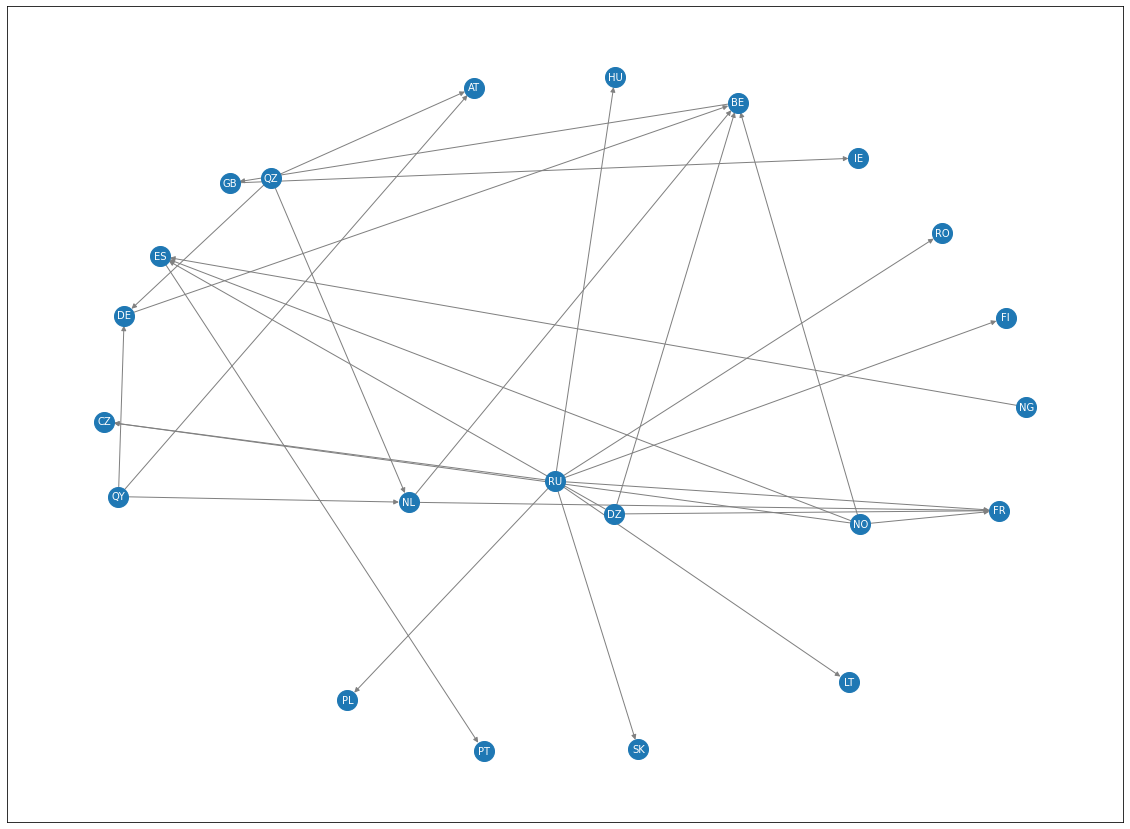

In [16]:
plt.figure(figsize=(20,15))
nx.draw_networkx(G,pos=coord,node_size=400,font_color="white",font_size=10,edge_color="gray")

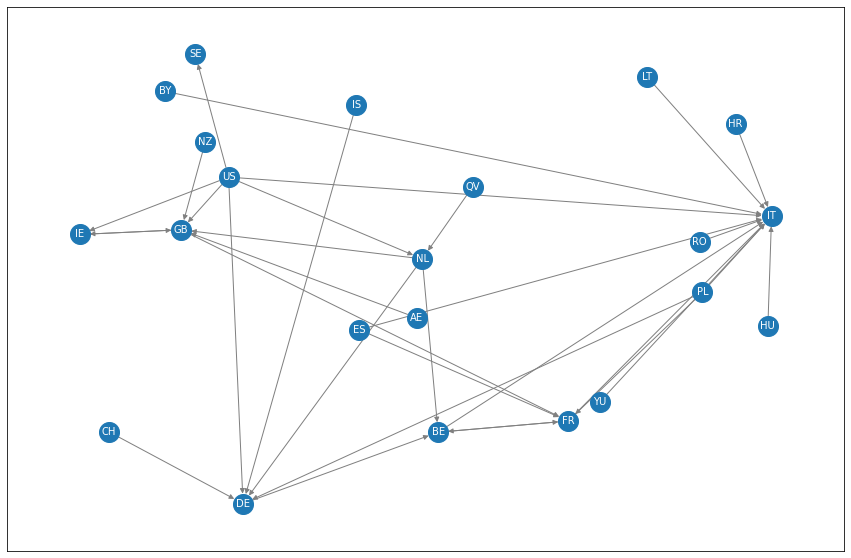

In [ ]:
plt.figure(figsize=(15,10))
nx.draw_networkx(G,node_size=400,font_color="white",font_size=10,edge_color="gray")

In [ ]:
import eurostat

In [ ]:
es_df = eurostat.get_toc_df()

In [ ]:
es_df

,title,code,type,last update of data,last table structure change,data start,data end
0,Database by themes,data,folder,,,,
1,General and regional statistics,general,folder,,,,
2,European and national indicators for short-ter...,euroind,folder,,,,
3,Business and consumer surveys (source: DG ECFIN),ei_bcs,folder,,,,
4,Consumer surveys (source: DG ECFIN),ei_bcs_cs,folder,,,,
...,...,...,...,...,...,...,...
10599,Enterprises that provided training to develop/...,isoc_ske_ittn2,dataset,28.01.2022,09.12.2021,2012,2020
10600,Participation in education and training - cont...,sks_devcvt,folder,,,,
10601,Enterprises providing training by type of trai...,trng_cvt_01s,dataset,26.02.2019,08.02.2021,2005,2015
10602,Participants in CVT courses by sex and size cl...,trng_cvt_12s,dataset,26.02.2019,08.02.2021,2005,2015


In [ ]:
es_df[es_df.code == "comext"].title

5657    Full access to detailed statistics on internat...
6264    Full access to detailed statistics on internat...
Name: title, dtype: object

In [ ]:
eurostat.subset_toc_df(es_df,"comext")

,title,code,type,last update of data,last table structure change,data start,data end
5657,Full access to detailed statistics on internat...,comext,dataset,,,,
6264,Full access to detailed statistics on internat...,comext,dataset,,,,


In [ ]:
toc_smdx = eurostat.get_avail_sdmx_df()

In [ ]:
bec_df = eurostat.get_sdmx_data_df("DS-032655",StartPeriod="2001",EndPeriod="2001",
                          filter_pars={'FLOW':['1'],'INDICATORS':["VALUE_IN_EUROS"],"PRODUCT":["TOTAL"],"PARTNER":["EU27_2020_INTRA","EU27_2020_EXTRA"]},
                          flags=False)

Progress: 100.0%


In [ ]:
bec_df

,PARTNER,INDICATORS,PRODUCT,FLOW,REPORTER,FREQ,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2001
0,EU27_2020_INTRA,VALUE_IN_EUROS,TOTAL,1,AT,M,5.31903919E9,5.387299879E9,6.029446865E9,5.433461472E9,5.721184006E9,5.357105271E9,5.419400136E9,4.929767307E9,5.34927959E9,6.030845506E9,5.739639286E9,4.764060003E9,6.5480528511E10
1,EU27_2020_INTRA,VALUE_IN_EUROS,TOTAL,1,BE,M,1.0910405927E10,1.0913669378E10,1.1863208043E10,1.0520273945E10,1.1186272716E10,1.0987478245E10,9.495579139E9,9.223005395E9,1.0767726932E10,1.0748840717E10,1.0547579987E10,1.0974764687E10,1.28138805111E11
2,EU27_2020_INTRA,VALUE_IN_EUROS,TOTAL,1,BG,M,2.85639275E8,3.00737627E8,3.52615467E8,3.57288987E8,4.08539586E8,4.02328921E8,4.33988346E8,3.79789576E8,3.14108061E8,4.30504144E8,4.05680634E8,3.67772793E8,4.438993417E9
3,EU27_2020_INTRA,VALUE_IN_EUROS,TOTAL,1,CY,M,1.35450419E8,1.23731866E8,1.69499259E8,1.62726899E8,1.71592747E8,1.74189921E8,1.55569816E8,1.46179385E8,1.22406663E8,1.81102769E8,1.59452553E8,1.52782358E8,1.854684655E9
4,EU27_2020_INTRA,VALUE_IN_EUROS,TOTAL,1,CZ,M,2.104184968E9,2.290048588E9,2.683485248E9,2.345386212E9,2.499875293E9,2.417778528E9,2.399502301E9,2.282529549E9,2.103852457E9,2.757558924E9,2.53621378E9,2.211202211E9,2.8631618059E10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,EU27_2020_EXTRA,VALUE_IN_EUROS,TOTAL,1,PT,M,9.43963162E8,9.69718244E8,1.147878418E9,1.055695492E9,1.247021927E9,1.138985564E9,1.064683236E9,9.75676043E8,8.98248683E8,1.069493513E9,1.009429925E9,9.57569584E8,1.2478363791E10
62,EU27_2020_EXTRA,VALUE_IN_EUROS,TOTAL,1,RO,M,4.85521375E8,5.44878084E8,5.05854898E8,5.39293829E8,6.52677041E8,5.30710119E8,4.62388413E8,4.95089058E8,4.36328047E8,5.17032666E8,5.10823692E8,6.35661248E8,6.31625847E9
63,EU27_2020_EXTRA,VALUE_IN_EUROS,TOTAL,1,SE,M,2.56841235E9,2.246121557E9,2.564381056E9,2.482150237E9,2.412758486E9,2.141302095E9,1.976804954E9,2.2692616E9,1.984088608E9,2.32763846E9,2.15740091E9,1.882903106E9,2.7013223419E10
64,EU27_2020_EXTRA,VALUE_IN_EUROS,TOTAL,1,SI,M,1.85710255E8,1.88861409E8,2.14728798E8,2.00791708E8,2.21544089E8,2.14032567E8,2.15568358E8,1.68519339E8,1.94545495E8,2.00973987E8,2.13872257E8,1.98400889E8,2.417549151E9
